### Example of the use of the library that implements Namaster into the qubicsoft

by Claudia (September 2021)

In [1]:
from pylab import *
import os
import sys
from importlib import reload
import glob
import pickle

# Specific science modules
import healpy as hp
import numpy as np

# Specific qubic modules
from qubicpack.utilities import Qubic_DataDir
from pysimulators import FitsArray
import pysm3  as pysm 
import qubic
from qubic import SpectroImLib as si
from qubic import QubicSkySim as qss
from qubic import NamasterLib as nam
reload(nam)

rc('figure', figsize=(13, 10))
rc('font', size=12)


## Create a map without mask, from CAMB

In [2]:
#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
import os
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.1.3 installed at /home/claudia/miniconda3/envs/qubic/lib/python3.7/site-packages/camb


In [3]:
#Set up a set of parameters for CAMB (with r=0.1)
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0.1)
pars.set_for_lmax(2500, lens_potential_accuracy=1)
pars.WantTensors = True;

In [4]:
#calculate results for these parameters
results = camb.get_results(pars)

#camb.get_results()

In [5]:
#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


(2551, 4)


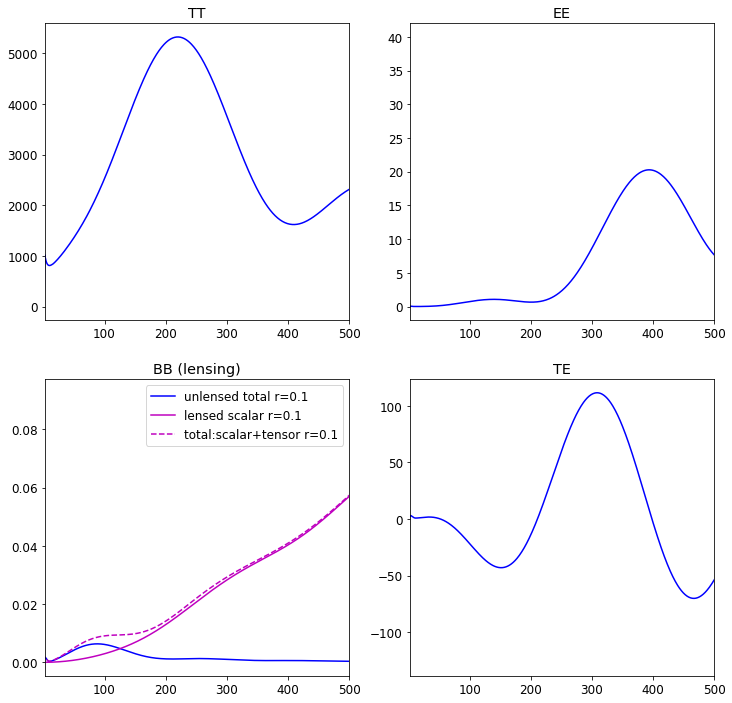

In [6]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']

unlensedCL=powers['unlensed_scalar']
unlensed_Tot=powers['unlensed_total']
lensed_SC=powers['lensed_scalar']


print(totCL.shape)
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(2,2, figsize = (12,12))
ax[0,0].plot(ls,totCL[:,0], color='b')
ax[0,0].set_title('TT')
#ax[0,1].plot(ls[2:], 1-unlensedCL[2:,0]/totCL[2:,0]);
#ax[0,1].set_title(r'$\Delta TT$')
ax[0,1].plot(ls,totCL[:,1], color='b')
ax[0,1].set_title('EE')
#ax[1,0].plot(ls,totCL[:,2], color='b')
#ax[1,0].plot(ls,totCL2[:,2], color='r')
#ax[1,0].set_title('BB (lensing)')
ax[1,0].plot(ls,unlensed_Tot[:,2], color='b',label='unlensed total r=0.1')
ax[1,0].plot(ls,lensed_SC[:,2], color='m',label='lensed scalar r=0.1')
ax[1,0].plot(ls,totCL[:,2], color='m',ls='--',label='total:scalar+tensor r=0.1')
ax[1,0].legend()
ax[1,0].set_title('BB (lensing)')
ax[1,1].plot(ls,totCL[:,3], color='b')
ax[1,1].set_title('TE')
#for ax in ax.reshape(-1): ax.set_xlim([2,2500]);
for ax in ax.reshape(-1): ax.set_xlim([2,500]);


### Generate map using hp.synfast

In [7]:
import healpy as hp

In [8]:
nside= 64 #128 #256  #512

### Go from $D_\ell$ to $C_\ell$

In [9]:
totCL.shape

(2551, 4)

In [10]:
print(ls)
ls.shape

ls = np.arange(totCL.shape[0])

factor = ls*(ls+1)/2./np.pi

print(factor)

#traspose to make the division:
cl_total = totCL.T/factor 

cl_total[:,0] = 0.

print(cl_total)

# cl_unlensed has the proper shape to create the maps, so we don't traspose again.


[   0    1    2 ... 2548 2549 2550]
[0.00000000e+00 3.18309886e-01 9.54929659e-01 ... 1.03368780e+06
 1.03449917e+06 1.03531086e+06]
[[ 0.00000000e+00  0.00000000e+00  1.06943377e+03 ...  6.16120823e-05
   6.14510700e-05  6.12916986e-05]
 [ 0.00000000e+00  0.00000000e+00  3.44723206e-02 ...  2.64680231e-06
   2.64243622e-06  2.63792377e-06]
 [ 0.00000000e+00  0.00000000e+00  1.70575473e-03 ...  2.50132762e-08
   2.49636672e-08  2.49142007e-08]
 [ 0.00000000e+00  0.00000000e+00  2.78398581e+00 ... -3.41481780e-06
  -3.42867625e-06 -3.44240922e-06]]


/home/claudia/miniconda3/envs/qubic/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


#### Map with FWHM=0 and pixwin=False

In [11]:
np.random.seed(0)


#lmax= 1000

#notar que el espectro que sale del CAMB son en realidad Dl.

#Hago el mapa con synfast usando los Cl's:
maps=hp.synfast(cl_total, nside, pixwin=False, fwhm=0.0, sigma=None, new=True, verbose=True)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


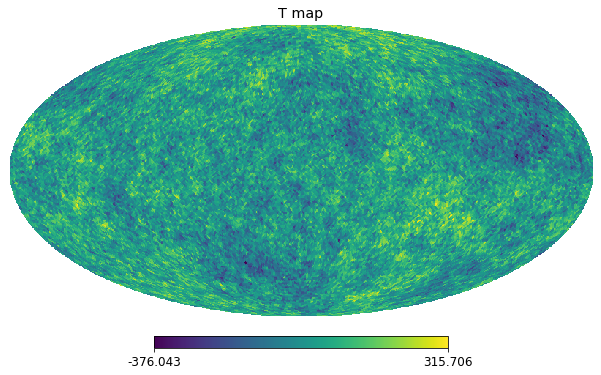

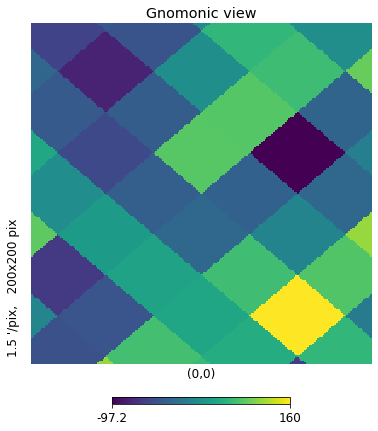

In [12]:
hp.mollview(maps[0],title='T map')    #ver option de subplot dentro de mollview

hp.gnomview(maps[0])

## Create coverage map

In [13]:
#Read the QUBIC dictionary

d = qubic.qubicdict.qubicDict()
d.read_from_file('pipeline_demo.dict')


In [14]:
center = qubic.equ2gal(d['RA_center'], d['DEC_center'])

d['nside'] = nside


In [15]:
# Create a coverage map (following instructions at):

# https://chat.in2p3.fr/group/GD88WWD8F7MWQHtMG?msg=nJf7wS38h2dvWa77v


# Pointing strategy
p = qubic.get_pointing(d)
print('=== Pointing DONE! ===')

# Model of the scene at the time of observation
s = qubic.QubicScene(d)

# Create a monofrequency Instrument.
q = qubic.QubicInstrument(d)

# Create an acquisition operator which combines all relevant information
#scene, instrument configuration and pointing strategy. 
a = qubic.QubicAcquisition(q, p, s, d)

# Get coverage map
# i.e. how many times were seen each pixel of the sky (not trivial because of the synthetic beam)
coverage = a.get_coverage()

You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.
=== Pointing DONE! ===
Info cosmos: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.


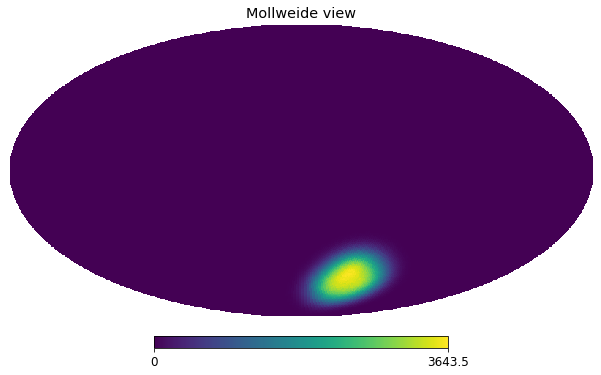

In [16]:
#Visualize the coverage: 
hp.mollview(coverage)


In [17]:
print(coverage.min())
print(coverage.max())


0.0
3643.4993736991387


In [18]:
print("Approximate resolution at NSIDE {} is {:.2} deg".format(nside, hp.nside2resol(nside, arcmin=True) / 60))


Approximate resolution at NSIDE 64 is 0.92 deg


### Word of caution: 

If I save the coverage map to disk, and then read it back with healpy, it differs from the one stored in memory (but only due to the precision with which numpy arrays are stored). Justo to bear this in mind. See the piece of code below:

In [19]:
#I write the coverage map to disk:
hp.write_map("my_coverage_claudia.fits", coverage, overwrite=True)

#I read the coverage map from disk:
cov_claudia =  hp.read_map("my_coverage_claudia.fits")

#The difference between both maps is not zero for all pixels!

#Differences of both coverage maps:
difference = coverage - cov_claudia

#Indices where the array above is non-zero:
nonzero_idx = np.nonzero(difference)

max_diff = difference[nonzero_idx].max()

print("maximum value of the difference in the coverage map: ", max_diff)

# By default, NumPy uses up to 8 digits of precision and will not suppress scientific notation.


NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
maximum value of the difference in the coverage map:  0.00012204891027067788


/home/claudia/miniconda3/envs/qubic/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/claudia/miniconda3/envs/qubic/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


In [20]:
difference[nonzero_idx].max()

0.00012204891027067788

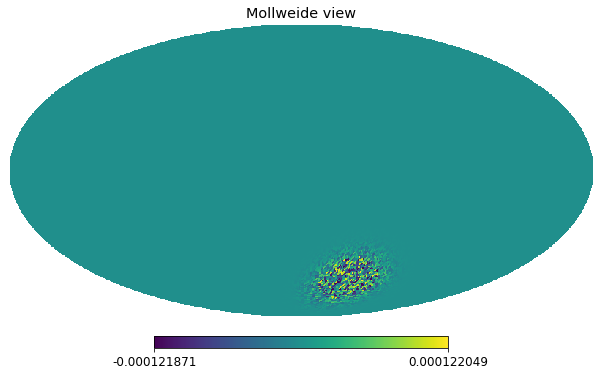

In [21]:
hp.mollview(difference)


## Create the mask with the coverage map

In [22]:
# ############################################
# From the script: Analyse-CMB-Maps_FitNoise:
# ############################################

# Create a Mask
seenpix = coverage > (np.max(coverage)/10)

In [23]:
# Create a Namaster object
lmin = 30
#lmax = 3 * d['nside'] - 1
lmax = 3 * nside - 1
delta_ell = 25
Namaster = nam.Namaster(seenpix, lmin=lmin, lmax=lmax, delta_ell=delta_ell)

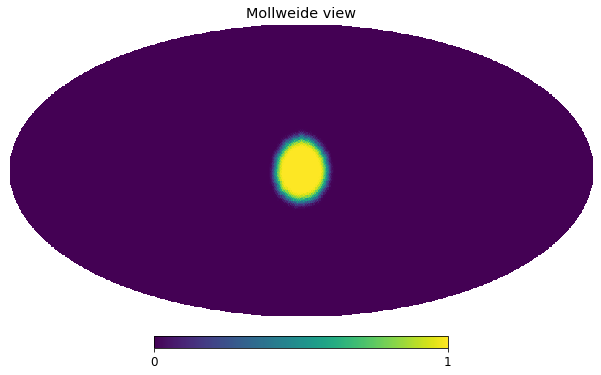

In [24]:
# Make a mask
mask_apo = Namaster.get_apodized_mask()
hp.mollview(mask_apo, rot=center)

In [25]:
ell_binned, b = Namaster.get_binning(nside)

In [26]:
clname = ['TT', 'EE', 'BB', 'TE']

#maps = np.stack((out_ti,out_qi,out_ui))

ell_binned, spectra, w = Namaster.get_spectra(maps, mask_apo, purify_e=False, purify_b=True,  beam_correction=True, pixwin_correction=False,  verbose=False)

## Compare the output of Namaster with the theoretical spectra

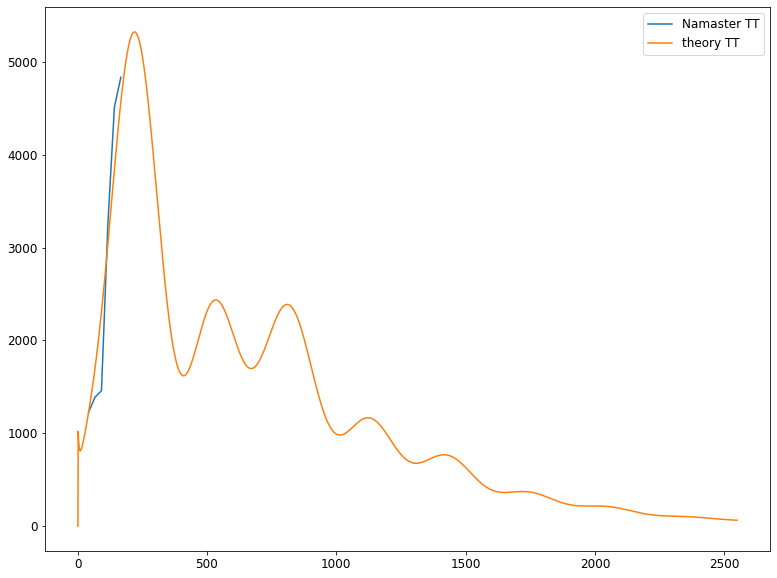

In [27]:
plt.plot(ell_binned,spectra.T[0],label='Namaster TT')
plt.plot(ls,totCL.T[0], label='theory TT')
plt.legend()

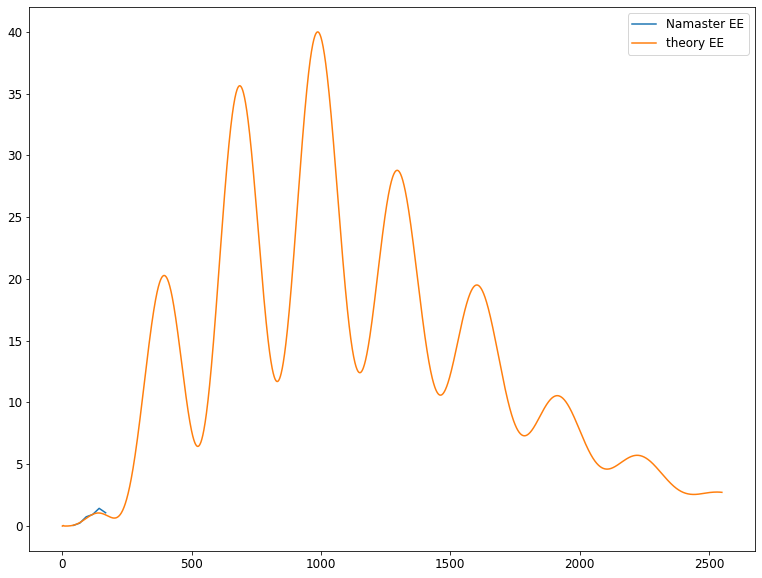

In [28]:
plt.plot(ell_binned,spectra.T[1],label='Namaster EE')
plt.plot(ls, totCL.T[1], label='theory EE')
plt.legend()

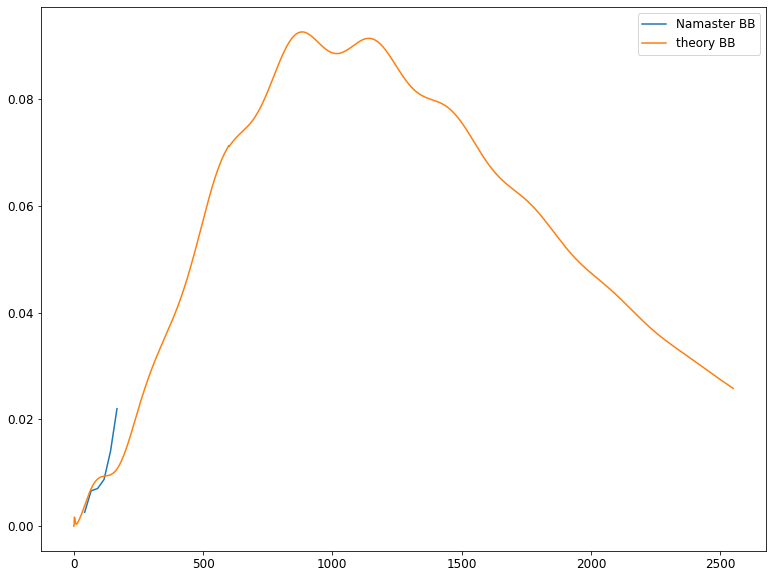

In [29]:
plt.plot(ell_binned,spectra.T[2],label='Namaster BB')
plt.plot(ls, totCL.T[2], label='theory BB')
plt.legend()

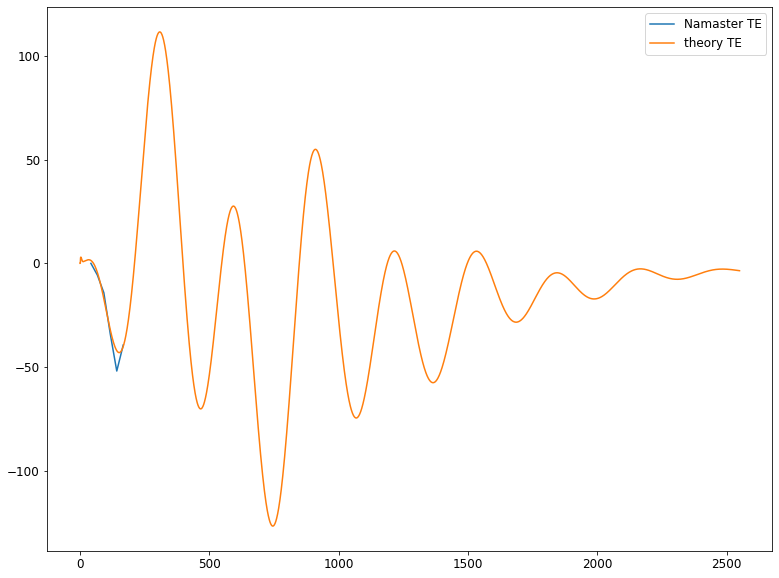

In [30]:
plt.plot(ell_binned,spectra.T[3],label='Namaster TE')
plt.plot(ls, totCL.T[3], label='theory TE')
plt.legend()